In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import stats
# set font size
mpl.rcParams.update({'font.size': 8})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [2]:
nerd_sqlite = '../../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [3]:
rg_ids = [123, 124, 129, 130]  # P4P6 rg_ids

query = """
SELECT *
FROM probe_tc_fits_view
WHERE fit_kind = 'round3_constrained'
  AND rg_id IN ({})
  AND rt_protocol = 'MRT'
ORDER BY rg_id
""".format(",".join(["?"] * len(rg_ids)))

df = read_sql(query, params=rg_ids)
conn.close()

In [4]:
# get max log_kobs for each nt_base and save in dict
max_logkobs = {}
for base in df['nt_base'].unique():
    df_base = df[df['nt_base'] == base]
    max_logkobs[base] = df_base['log_kobs'].max()
max_logkobs

def calc_dG(logkobs, logkadd):
    R = 1.9872036e-3  # kcal/(mol*K)
    T = 298.15  # K
    
    logKKp1 = logkobs - logkadd
    KKp1 = np.exp(logKKp1) # K / (K+1)
    K = KKp1 / (1 - KKp1)
    dG = -R * T * np.log(K)

    return dG


# calculate dG using base-specific max log_kobs
df['dG'] = df.apply(lambda row: calc_dG(row['log_kobs'], max_logkobs[row['nt_base']]), axis=1)
df

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_81621/4165455530.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  K = KKp1 / (1 - KKp1)


,fit_run_id,rg_id,nt_id,fit_kind,rg_label,temperature,probe,probe_conc,rt_protocol,buffer_id,...,nt_site,nt_base,kobs,log_kobs,log_kdeg,log_kobs_err,log_kdeg_err,r2,metadata_json,dG
0,274536,123,797,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,103,G,0.000660,-7.323764,-8.067974,0.296183,0.0,0.487337,"{""base"": ""G"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",1.337060
1,274537,123,798,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,104,A,0.022931,-3.775280,-8.067974,0.039808,0.0,0.981779,"{""base"": ""A"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.411026
2,274538,123,799,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,105,A,0.017473,-4.047125,-8.067974,0.045539,0.0,0.976153,"{""base"": ""A"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.638676
3,274539,123,800,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,106,U,0.000927,-6.983541,-8.067974,0.267403,0.0,0.538394,"{""base"": ""U"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.743259
4,274540,123,801,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,107,U,0.001103,-6.809645,-8.067974,0.144518,0.0,0.799772,"{""base"": ""U"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.607229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,275511,124,939,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,245,G,0.000381,-7.873467,-8.242844,0.577642,0.0,0.374830,"{""base"": ""G"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.688418
412,275516,124,944,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,250,G,0.000255,-8.273244,-8.242844,1.030822,0.0,0.158407,"{""base"": ""G"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.936470
413,275517,124,945,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,251,G,0.000253,-8.280811,-8.242844,1.323388,0.0,0.102497,"{""base"": ""G"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.941123
414,275520,124,948,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,254,G,0.000547,-7.510987,-8.242844,0.923467,0.0,0.190010,"{""base"": ""G"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.458484


In [10]:
## Analysis of correlation

def keep_higher_r2(df):
    """
     keep_higher_r2 between duplicate RT runs of the same reactions
    """
    for site in df['nt_site'].unique():
        # drop row with lower r2
        df_site = df[df['nt_site'] == site]
        if len(df_site) != 2:
            continue
        if df_site.iloc[0]['r2'] > df_site.iloc[1]['r2']:
            df = df.drop(df_site.index[1])
        else:
            df = df.drop(df_site.index[0])
    return df

df_nomg = df[df['buffer_id'] == 2]
df_nomg = keep_higher_r2(df_nomg)
df_mg = df[df['buffer_id'] == 3]
df_mg = keep_higher_r2(df_mg)
df_mg

# merge df_nomg and df_mg on nt_site and keep the following: nt_site, nt_base, log_kobs, log_kobs_err, dG, r2
# add suffix to all but nt_site and nt_base
df_merged = pd.merge(df_nomg[['nt_site', 'nt_base', 'log_kobs', 'log_kobs_err', 'dG', 'r2']],
                     df_mg[['nt_site', 'log_kobs', 'log_kobs_err', 'dG', 'r2']],
                     on=['nt_site'],
                     suffixes=('_nomg', '_mg'))

# filter to A and C only
df_merged_AC = df_merged[df_merged['nt_base'].isin(['A', 'C'])]

# filter to R2 > 0.5
df_merged_AC = df_merged_AC[(df_merged_AC['r2_nomg'] > 0.5) & (df_merged_AC['r2_mg'] > 0.5)]

In [11]:
canonical_annots = pd.read_csv('p4p6_canonical_annots.csv')

# merge on nt_site and nt_base
df_merged_AC = pd.merge(df_merged_AC, canonical_annots, on=['nt_site', 'nt_base'], how='left')

ddG_merged = df_merged_AC.copy()
ddG_merged['ddG'] = df_merged_AC['dG_mg'] - df_merged_AC['dG_nomg']

# melt dG_nomg and dG_mg into dG and new column "buffer" 
df_merged_AC = pd.melt(df_merged_AC,
                       id_vars=['nt_site', 'nt_base', 'canonical'],
                       value_vars=['dG_nomg', 'dG_mg'],
                       var_name='buffer',
                       value_name='dG')
df_merged_AC

,nt_site,nt_base,canonical,buffer,dG
0,104,A,0.0,dG_nomg,0.411026
1,105,A,0.0,dG_nomg,0.638676
2,109,C,0.0,dG_nomg,0.707925
3,113,A,0.0,dG_nomg,0.743639
4,114,A,0.0,dG_nomg,0.043210
...,...,...,...,...,...
135,261,A,0.0,dG_mg,1.604038
136,262,A,0.0,dG_mg,1.192756
137,263,C,0.0,dG_mg,1.988792
138,265,A,0.0,dG_mg,2.229078


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


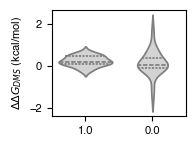

In [42]:
fig, ax = plt.subplots(figsize=(2, 1.5))
sns.violinplot(data = ddG_merged, x='canonical', y='ddG', inner='quartiles', order=[1.0, 0.0], color = 'lightgray')
# remove x label
ax.set_xlabel('')
# set y label
ax.set_ylabel(r'$\Delta\Delta G_{DMS}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('p4p6_ddG_swarmplots.pdf')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


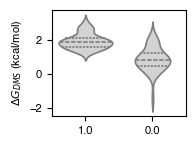

In [41]:
# sns swarmplot dG_nomg vs dG_mg colored by canonical annotation
fig, ax = plt.subplots(figsize=(2, 1.5))
sns.violinplot(data=df_merged_AC, x='canonical', y='dG', order=[1.0, 0.0], inner = 'quartiles', color='lightgray', ax = ax)
# remove x label
ax.set_xlabel('')
# set y label
ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
plt.tight_layout()
plt.savefig('p4p6_dG_swarmplots.pdf')

In [8]:
df_merged_AC[df_merged_AC['canonical'] == 1][['nt_site', 'nt_base', 'dG_nomg', 'dG_mg', 'canonical']]

KeyError: "['dG_nomg', 'dG_mg'] not in index"

Text(0.5, 1.0, 'Swarmplot of dG values with and without Mg²⁺')

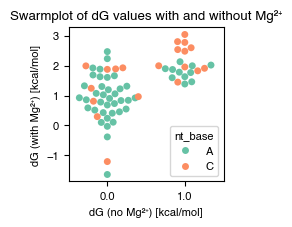

In [ ]:
# sns swarmplot dG_nomg vs dG_mg colored by canonical annotation
plt.figure(figsize=(2, 2))
sns.swarmplot(data=df_merged_AC, x='canonical', y='dG_mg', hue='nt_base', palette='Set2')
plt.xlabel('dG (no Mg²⁺) [kcal/mol]')
plt.ylabel('dG (with Mg²⁺) [kcal/mol]')
plt.title('Swarmplot of dG values with and without Mg²⁺')